/Users/socheata/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loading FastText model with Gensim...


100%|██████████| 15000/15000 [00:02<00:00, 5166.70it/s]


Computing TF-IDF weights...
Extracting TF-IDF weighted embeddings...


100%|██████████| 15000/15000 [00:05<00:00, 2677.84it/s]


Saving full 300-dim embeddings...
Normalizing embeddings...
Reducing to 100 dimensions with PCA...
Explained variance with 100 components: 0.8678
Saved embeddings and labels to /Users/socheata/Documents/FYP-Khmer-Classification/FastText_Features_Fun
Visualizing embeddings with PCA...


/var/folders/9n/ttnnmpy11wb3xzbvs4djr1yr0000gn/T/ipykernel_1038/3404491442.py:135: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(categories))


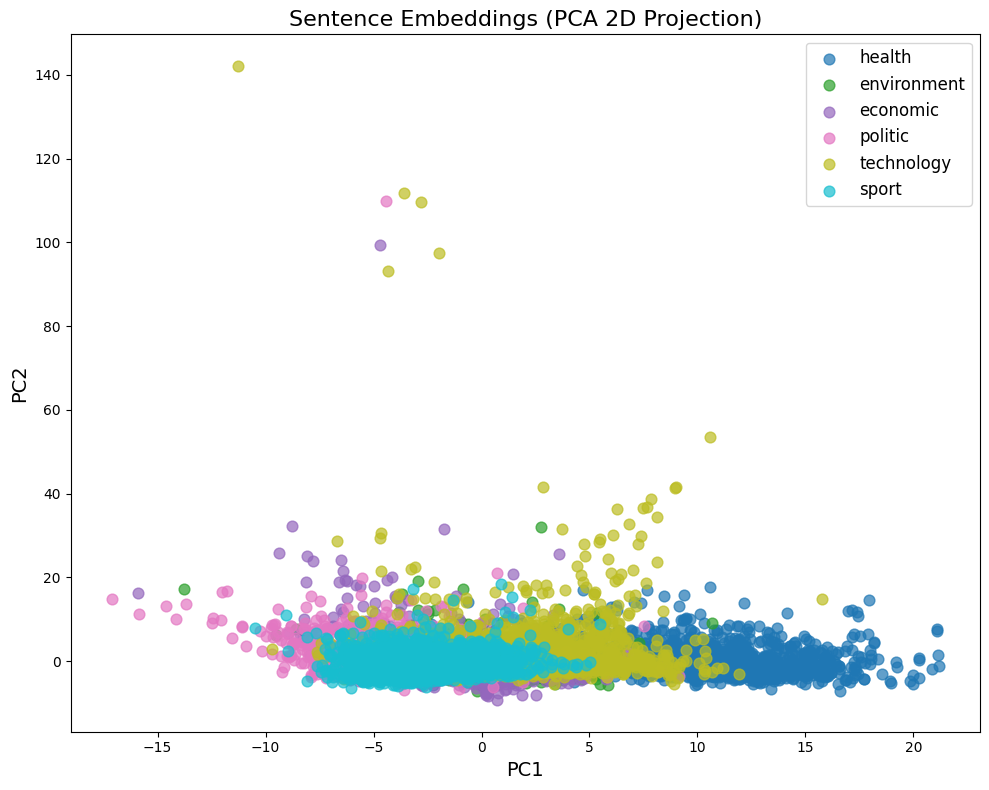

Visualizing embeddings with t-SNE...


/Users/socheata/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


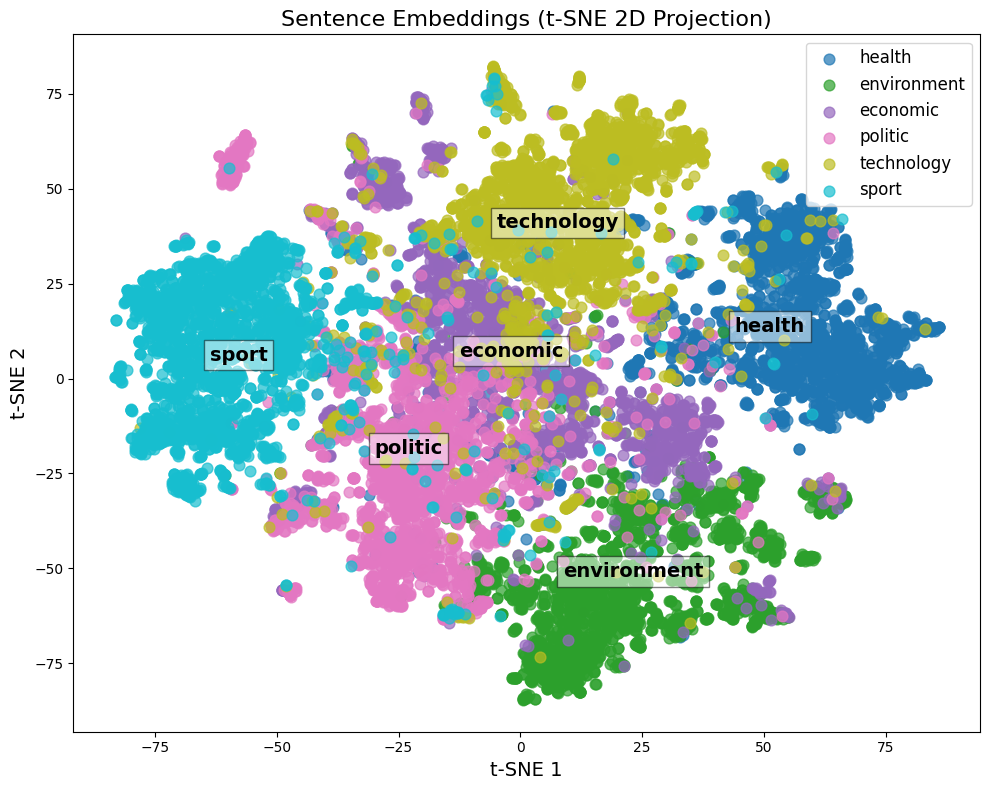

Analyzing category separation...


TypeError: Image data of dtype object cannot be converted to float

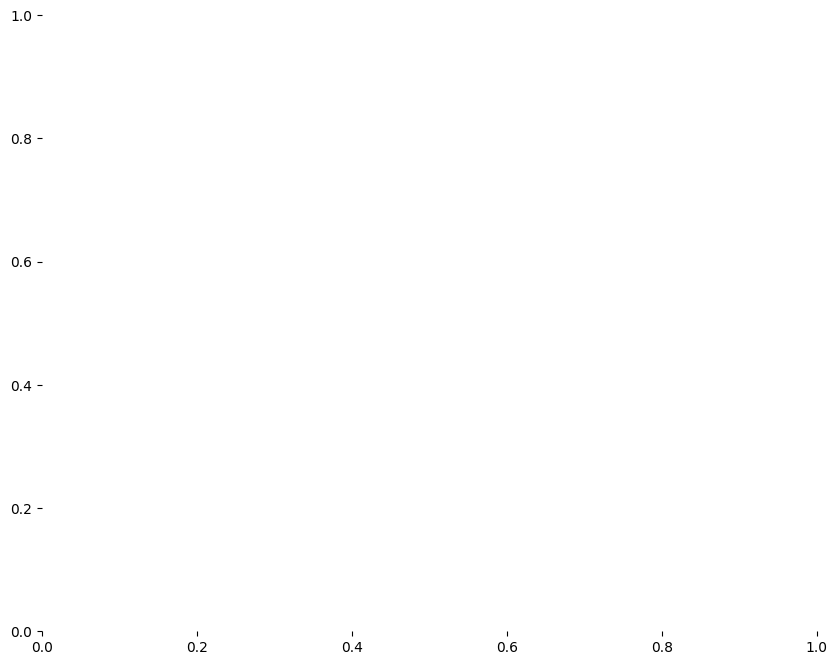

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from gensim.models.fasttext import load_facebook_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Output directory
OUTPUT_DIR = "/Users/socheata/Documents/FYP-Khmer-Classification/FastText_Features_Fun"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Paths
METADATA_PATH = "/Users/socheata/Documents/FYP-Khmer-Classification/original_articles/metadata.csv"
ARTICLES_DIR = "../../Preprocess_articles"
MODEL_PATH = "cc.km.300.bin"  # Update if your model is elsewhere

# Load metadata
df = pd.read_csv(METADATA_PATH)

# Load FastText model using Gensim
print("Loading FastText model with Gensim...")
ft = load_facebook_model(MODEL_PATH)

def get_article_text(doc_id):
    file_path = os.path.join(ARTICLES_DIR, f"{doc_id}.txt")
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found.")
        return ""
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read()

# Collect all texts for TF-IDF calculation
print("Collecting texts for TF-IDF calculation...")
all_texts = []
all_doc_ids = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    doc_id = row['docId']
    text = get_article_text(doc_id)
    all_texts.append(text)
    all_doc_ids.append(doc_id)

# Compute TF-IDF weights
print("Computing TF-IDF weights...")
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8)
tfidf_matrix = vectorizer.fit_transform(all_texts)
vocabulary = vectorizer.vocabulary_
idf_values = vectorizer.idf_

# Create word-to-weight mapping
word_to_weight = {word: idf_values[idx] for word, idx in vocabulary.items()}

def get_weighted_sentence_embedding(text, model, word_weights):
    """Create weighted sentence embedding using TF-IDF weights"""
    words = text.strip().split()
    if not words:
        return np.zeros(model.vector_size)
    
    vectors = []
    weights = []
    
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
            # Use IDF as weight if available, else default to 1.0
            weights.append(word_weights.get(word, 1.0))
    
    if not vectors:
        return np.zeros(model.vector_size)
    
    # Use weighted average if weights exist
    weights = np.array(weights)
    sum_weights = np.sum(weights)
    
    if sum_weights > 0:
        # Normalize weights
        weights = weights / sum_weights
        # Weighted average
        return np.average(vectors, weights=weights, axis=0)
    else:
        # If all weights are 0, use simple average
        return np.mean(vectors, axis=0)

# Extract enhanced embeddings
print("Extracting TF-IDF weighted embeddings...")
weighted_embeddings = []
doc_ids = []

for doc_id, text in tqdm(zip(all_doc_ids, all_texts), total=len(all_texts)):
    emb = get_weighted_sentence_embedding(text, ft, word_to_weight)
    weighted_embeddings.append(emb)
    doc_ids.append(doc_id)

weighted_embeddings = np.vstack(weighted_embeddings)

# Save full 300-dim embeddings
print("Saving full 300-dim embeddings...")
np.save(os.path.join(OUTPUT_DIR, "sentence_embeddings_full.npy"), weighted_embeddings)

# Normalize embeddings before reduction
print("Normalizing embeddings...")
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(weighted_embeddings)

# Generate 100-dim embeddings with PCA
print("Reducing to 100 dimensions with PCA...")
pca = PCA(n_components=100)
embeddings_100d = pca.fit_transform(embeddings_scaled)
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained variance with 100 components: {explained_variance:.4f}")

# Save reduced embeddings
np.save(os.path.join(OUTPUT_DIR, "sentence_embeddings.npy"), embeddings_100d)
pd.DataFrame(embeddings_100d, index=doc_ids).to_csv(os.path.join(OUTPUT_DIR, "sentence_embeddings.csv"))

# Save labels (categories) in the same order as embeddings
labels = df.set_index('docId').loc[doc_ids]['category'].values
np.save(os.path.join(OUTPUT_DIR, "labels.npy"), labels)
pd.DataFrame({'docId': doc_ids, 'category': labels}).to_csv(os.path.join(OUTPUT_DIR, "labels.csv"), index=False)

print(f"Saved embeddings and labels to {OUTPUT_DIR}")

# Visualization with 100D embeddings
print("Visualizing embeddings with PCA...")
pca_vis = PCA(n_components=2)
embeddings_2d = pca_vis.fit_transform(embeddings_100d)

plt.figure(figsize=(10, 8))
categories = list(set(labels))
colors = plt.cm.get_cmap('tab10', len(categories))

for idx, cat in enumerate(categories):
    inds = [i for i, l in enumerate(labels) if l == cat]
    plt.scatter(embeddings_2d[inds, 0], embeddings_2d[inds, 1], 
                label=cat, alpha=0.7, color=colors(idx), s=60)

plt.legend(fontsize=12)
plt.title("Sentence Embeddings (PCA 2D Projection)", fontsize=16)
plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "embeddings_pca.png"), dpi=300)
plt.show()

# t-SNE with improved parameters
print("Visualizing embeddings with t-SNE...")
tsne = TSNE(
    n_components=2, 
    perplexity=30,  # Increased from 5 for better clustering
    n_iter=1000,    # More iterations for better convergence
    learning_rate=200,
    random_state=42
)
embeddings_tsne = tsne.fit_transform(embeddings_100d)

plt.figure(figsize=(10, 8))
for idx, cat in enumerate(categories):
    inds = [i for i, l in enumerate(labels) if l == cat]
    plt.scatter(embeddings_tsne[inds, 0], embeddings_tsne[inds, 1], 
                label=cat, alpha=0.7, color=colors(idx), s=60)
    
    # Add category centroid labels
    centroid_x = np.mean(embeddings_tsne[inds, 0])
    centroid_y = np.mean(embeddings_tsne[inds, 1])
    plt.annotate(cat, (centroid_x, centroid_y), fontsize=14, 
                 fontweight='bold', ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.5))

plt.legend(fontsize=12)
plt.title("Sentence Embeddings (t-SNE 2D Projection)", fontsize=16)
plt.xlabel("t-SNE 1", fontsize=14)
plt.ylabel("t-SNE 2", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "embeddings_tsne.png"), dpi=300)
plt.show()

# Save preprocessing artifacts for consistent prediction
import joblib
joblib.dump(scaler, os.path.join(OUTPUT_DIR, "embedding_scaler.joblib"))
joblib.dump(pca, os.path.join(OUTPUT_DIR, "pca_reducer.joblib"))
joblib.dump(word_to_weight, os.path.join(OUTPUT_DIR, "word_weights.joblib"))

# Add category separation analysis
print("Analyzing category separation...")
from sklearn.metrics import silhouette_score

category_indices = {}
for cat in categories:
    category_indices[cat] = [i for i, l in enumerate(labels) if l == cat]

# Calculate inter-category and intra-category similarity
category_similarity = pd.DataFrame(index=categories, columns=categories)
for cat1 in categories:
    for cat2 in categories:
        if cat1 == cat2:
            # Calculate intra-category similarity (average pairwise cosine)
            indices = category_indices[cat1]
            if len(indices) > 1:
                vecs = embeddings_100d[indices]
                sim_matrix = cosine_similarity(vecs)
                # Remove self-similarity (diagonal)
                np.fill_diagonal(sim_matrix, 0)
                avg_sim = sim_matrix.sum() / (sim_matrix.size - len(indices))
                category_similarity.loc[cat1, cat2] = avg_sim
            else:
                category_similarity.loc[cat1, cat2] = 1.0
        else:
            # Calculate inter-category similarity
            indices1 = category_indices[cat1]
            indices2 = category_indices[cat2]
            vecs1 = embeddings_100d[indices1]
            vecs2 = embeddings_100d[indices2]
            sim_matrix = cosine_similarity(vecs1, vecs2)
            avg_sim = sim_matrix.mean()
            category_similarity.loc[cat1, cat2] = avg_sim

# Plot category similarity heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(category_similarity, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Category Similarity Matrix", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "category_similarity.png"), dpi=300)
plt.show()

print("Embedding extraction and analysis complete!")